In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

In [2]:
df = pd.read_csv('cleaned_df_dropped_fts.csv')
df.head()

,host_is_superhost,no_of_host_verifications,host_response_time,number_of_reviews,amenities_count,calculated_host_listings_count,reviews_per_month,price,security_deposit,cleaning_fee,...,price_per_person,days_since_calendar_updated,account_duration_days,space_char_count,neighborhood_overview_char_count,notes_char_count,host_about_char_count,space_char_count_grouped,neighborhood_overview_char_count_grouped,notes_char_count_grouped
0,0,4,2,207,10,2,4.07,85.0,0.0,0.0,...,21.250000,28,1607,1000,0,0,372,20,1,1
1,1,6,1,43,16,6,1.48,150.0,100.0,40.0,...,37.500000,0,1047,1000,167,1000,74,20,4,20
2,0,5,2,20,21,2,1.15,975.0,1000.0,300.0,...,88.636364,35,571,1000,669,155,343,20,14,4
3,0,5,1,38,13,1,0.89,450.0,700.0,125.0,...,75.000000,49,1497,488,492,9,354,10,10,1
4,1,4,1,58,7,1,2.46,80.0,150.0,0.0,...,40.000000,35,1314,1000,95,82,229,20,2,2


In [3]:
predictor_df = df.drop(['host_is_superhost'], axis = 1)

In [4]:
print("Data dims : ", predictor_df.shape)

Data dims :  (2803, 22)


In [4]:
superhost_df = df['host_is_superhost']

In [6]:
superhost_df.shape

(2803,)

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

In [6]:
X_train, X_test, y_train, y_test = train_test_split(predictor_df, superhost_df, test_size = 0.2)

## Attempt 1) Using SVM SMOTE

Utilise a variant of SMOTE (Synthetic Minority Over-sampling TEchnique), SVM SMOTE, that artificially synthesises samples for the minority class. For SVM SMOTE, a Support Vector Machine is used to locate the decision boundary (separating the 2 classes) and examples in the minority class that are close to the support vectors become the focus for generating synthetic examples. 

In addition to using a SVM, the technique attempts to select regions where there are fewer examples of the minority class and tries to extrapolate towards the class boundary.

In [8]:
from imblearn.over_sampling import SVMSMOTE

In [9]:
sm = SVMSMOTE()

In [10]:
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [11]:
X_train_res.shape

(3326, 22)

In [12]:
y_train_res.shape

(3326,)

In [13]:
y_train_res.value_counts()

1    1663
0    1663
Name: host_is_superhost, dtype: int64

# Random Forest Classification

In [14]:
from sklearn.ensemble import RandomForestClassifier

In [80]:
from sklearn.model_selection import validation_curve

Text(0, 0.5, 'score')

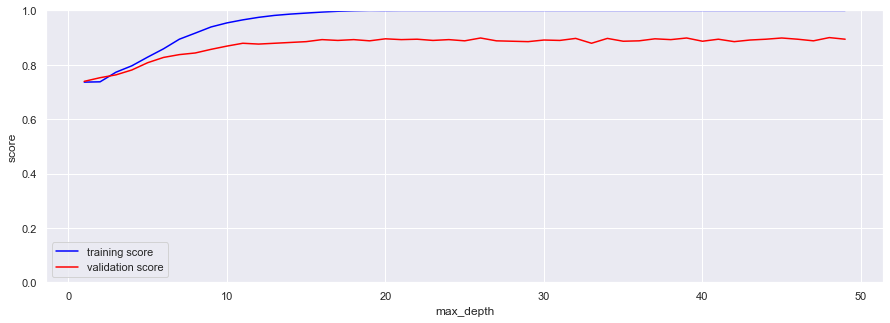

In [82]:
f_train_scores, f_test_scores = validation_curve(forest, 
                                             X_train_res, 
                                             y_train_res, 
                                             param_name="max_depth", 
                                             param_range=np.arange(1, 50),
                                             scoring="accuracy",
                                            cv=5,
                                            n_jobs = -1
                                             )
f, axes = plt.subplots(1, 1, figsize=(15, 5))
plt.plot(np.arange(1, 50), np.median(f_train_scores, 1), color='blue', label='training score')
plt.plot(np.arange(1, 50), np.median(f_test_scores, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('max_depth')
plt.ylabel('score')

In [83]:
np.argmax(np.median(f_test_scores, 1))

47

In [84]:
np.median(f_test_scores, 1)[47]

0.9001490312965723

In [85]:
f_param_grid = {'n_estimators': [100,200,300,500,1000],
               'max_depth': [50],
                'min_samples_split': [2,5,10]}

In [87]:
from sklearn.model_selection import GridSearchCV

In [88]:
f_grid = GridSearchCV(forest, f_param_grid, cv=5, n_jobs = -1)

In [89]:
f_grid.fit(X_train_res, y_train_res)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [90]:
f_grid.best_params_

{'max_depth': 50, 'min_samples_split': 2, 'n_estimators': 200}

In [15]:
forest = RandomForestClassifier(max_depth = 48, n_estimators = 200)

In [16]:
forest.fit(X_train_res, y_train_res) # train the model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=48, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [17]:
y_train_pred = forest.predict(X_train_res)
y_test_pred = forest.predict(X_test)

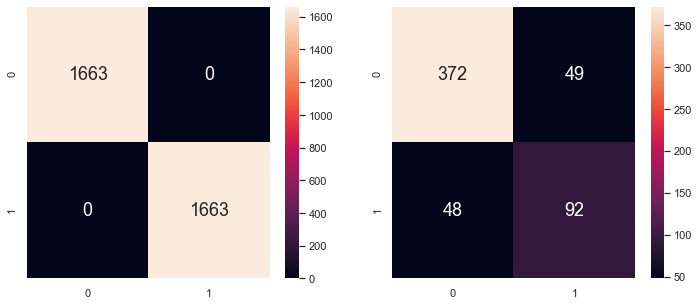

In [18]:
# Plot the Confusion Matrix
f, axes = plt.subplots(1, 2, figsize=(12, 5))
sb.heatmap(confusion_matrix(y_train_res, y_train_pred), annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

In [19]:
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", forest.score(X_train_res, y_train_res))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", forest.score(X_test, y_test))
print()

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 1.0

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.8270944741532977



In [20]:
TN_2, FP_2, FN_2, TP_2 = confusion_matrix(y_test, y_test_pred).ravel()

print(TN_2, FP_2, FN_2, TP_2)
print()

print("FPR =", FP_2/(FP_2+TN_2))

print("FNR =", FN_2/(FN_2+TP_2))

372 49 48 92

FPR = 0.1163895486935867
FNR = 0.34285714285714286


majority in each category is predicted correctly

# Support Vector Machine

In [22]:
from sklearn.svm import SVC
from sklearn.svm import NuSVC

In [23]:
svc = NuSVC()

In [24]:
svc.fit(X_train_res, y_train_res) # train the model

NuSVC(break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
      max_iter=-1, nu=0.5, probability=False, random_state=None, shrinking=True,
      tol=0.001, verbose=False)

In [25]:
y_train_pred3 = svc.predict(X_train_res)
y_test_pred3 = svc.predict(X_test)

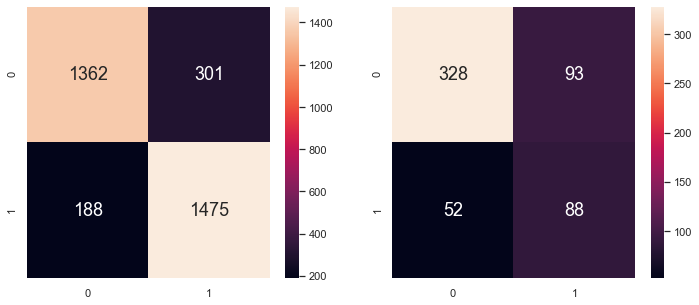

In [26]:
# Plot the Confusion Matrix
f, axes = plt.subplots(1, 2, figsize=(12, 5))
sb.heatmap(confusion_matrix(y_train_res, y_train_pred3), annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred3), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

In [27]:
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", svc.score(X_train_res, y_train_res))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", svc.score(X_test, y_test))
print()

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.8529765484064943

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.7415329768270945



In [28]:
TN_2, FP_2, FN_2, TP_2 = confusion_matrix(y_test, y_test_pred3).ravel()

print(TN_2, FP_2, FN_2, TP_2)
print()

print("FPR =", FP_2/(FP_2+TN_2))

print("FNR =", FN_2/(FN_2+TP_2))

328 93 52 88

FPR = 0.2209026128266033
FNR = 0.37142857142857144


Logistic Regression; uses a logistic function to model the probabilities for binary classification

In [29]:
from sklearn.linear_model import LogisticRegression

In [30]:
log = LogisticRegression( solver='liblinear')

In [31]:
log.fit(X_train_res, y_train_res) # train the model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [32]:
y_train_pred6 = log.predict(X_train_res)
y_test_pred6 = log.predict(X_test)

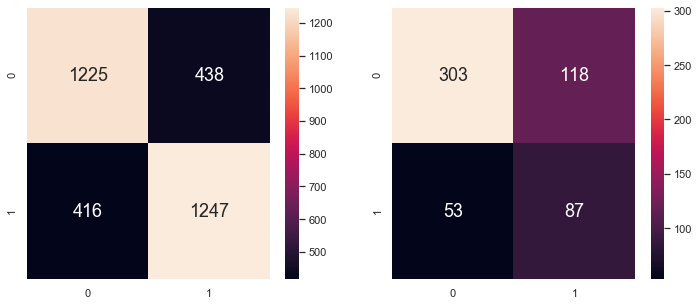

In [33]:
# Plot the Confusion Matrix
f, axes = plt.subplots(1, 2, figsize=(12, 5))
sb.heatmap(confusion_matrix(y_train_res, y_train_pred6), annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred6), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

In [34]:
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", log.score(X_train_res, y_train_res))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", log.score(X_test, y_test))
print()

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.7432351172579675

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.6951871657754011



### Extracting Test Set

In [35]:
test_df = pd.read_csv('cleaned_df_2020.csv')
test_df.shape

(5249, 23)

In [36]:
test_df.head()

,host_is_superhost,no_of_host_verifications,host_response_time,number_of_reviews,amenities_count,calculated_host_listings_count,reviews_per_month,price,security_deposit,cleaning_fee,...,price_per_person,days_since_calendar_updated,account_duration_days,space_char_count,neighborhood_overview_char_count,notes_char_count,host_about_char_count,space_char_count_grouped,neighborhood_overview_char_count_grouped,notes_char_count_grouped
0,1,8,1,32,39,2,0.23,296.0,500.0,250.0,...,32.888889,21,4221,1000,404,200,59,20,9,4
1,0,5,3,150,21,3,1.15,90.0,200.0,40.0,...,45.000000,92,3979,999,180,382,192,20,4,8
2,1,6,2,148,34,8,1.26,62.0,100.0,20.0,...,31.000000,15,3844,1000,669,205,2633,20,14,5
3,1,7,1,466,48,4,3.63,79.0,0.0,45.0,...,39.500000,5,3814,1000,308,1000,281,20,7,20
4,1,4,2,40,50,2,0.40,165.0,300.0,120.0,...,41.250000,2,3870,1000,248,193,805,20,5,4


In [37]:
predictor_df_test = test_df.drop(['host_is_superhost'], axis = 1)

In [38]:
print("Data dims : ", predictor_df_test.shape)

Data dims :  (5249, 22)


In [39]:
superhost_df_test = test_df['host_is_superhost']

In [40]:
print("Data dims : ", superhost_df_test.shape)

Data dims :  (5249,)


In [41]:
test_prediction_2 = forest.predict(predictor_df_test)

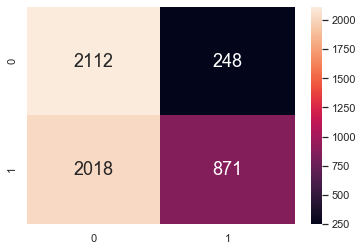

In [42]:
sb.heatmap(confusion_matrix(superhost_df_test, test_prediction_2), annot = True, fmt=".0f", annot_kws={"size": 18})


In [43]:
# Check the Goodness of Fit
print("Classification Accuracy \t:", forest.score(predictor_df_test, superhost_df_test))
print()

TN_Test2, FP_Test2, FN_Test2, TP_Test2 = confusion_matrix(superhost_df_test, test_prediction_2).ravel()

print(TN_Test2, FP_Test2, FN_Test2, TP_Test2)
print()

print("FPR =", FP_Test2/(FP_Test2+TN_Test2))

print("FNR =", FN_Test2/(FN_Test2+TP_Test2))

Classification Accuracy 	: 0.5682987235663935

2112 248 2018 871

FPR = 0.10508474576271186
FNR = 0.6985115957078574


In [44]:
test_prediction_3 = svc.predict(predictor_df_test)

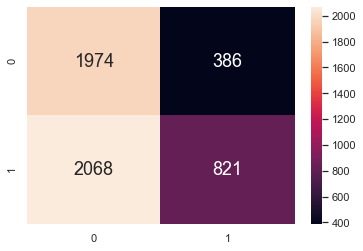

In [45]:
sb.heatmap(confusion_matrix(superhost_df_test, test_prediction_3), annot = True, fmt=".0f", annot_kws={"size": 18})

In [46]:
# Check the Goodness of Fit
print("Classification Accuracy \t:", svc.score(predictor_df_test, superhost_df_test))
print()

TN_Test3, FP_Test3, FN_Test3, TP_Test3 = confusion_matrix(superhost_df_test, test_prediction_3).ravel()

print(TN_Test3, FP_Test3, FN_Test3, TP_Test3)
print()

print("FPR =", FP_Test3/(FP_Test3+TN_Test3))

print("FNR =", FN_Test3/(FN_Test3+TP_Test3))

Classification Accuracy 	: 0.5324823775957325

1974 386 2068 821

FPR = 0.1635593220338983
FNR = 0.7158186223606784


In [47]:
test_prediction_5 = log.predict(predictor_df_test)

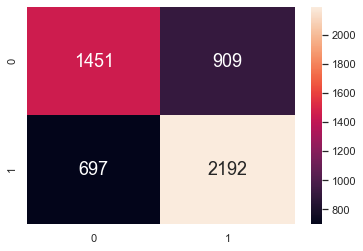

In [48]:
sb.heatmap(confusion_matrix(superhost_df_test, test_prediction_5), annot = True, fmt=".0f", annot_kws={"size": 18})

In [49]:
# Check the Goodness of Fit
print("Classification Accuracy \t:", log.score(predictor_df_test, superhost_df_test))
print()

TN_Test3, FP_Test3, FN_Test3, TP_Test3 = confusion_matrix(superhost_df_test, test_prediction_5).ravel()

print(TN_Test3, FP_Test3, FN_Test3, TP_Test3)
print()

print("FPR =", FP_Test3/(FP_Test3+TN_Test3))

print("FNR =", FN_Test3/(FN_Test3+TP_Test3))

Classification Accuracy 	: 0.6940369594208421

1451 909 697 2192

FPR = 0.38516949152542374
FNR = 0.24125995154032537


In [50]:
test_df.columns

Index(['host_is_superhost', 'no_of_host_verifications', 'host_response_time',
       'number_of_reviews', 'amenities_count',
       'calculated_host_listings_count', 'reviews_per_month', 'price',
       'security_deposit', 'cleaning_fee', 'availability_365',
       'listing_duration_days', 'hosting_duration_days', 'price_per_person',
       'days_since_calendar_updated', 'account_duration_days',
       'space_char_count', 'neighborhood_overview_char_count',
       'notes_char_count', 'host_about_char_count', 'space_char_count_grouped',
       'neighborhood_overview_char_count_grouped', 'notes_char_count_grouped'],
      dtype='object')

In [64]:
pd.set_option('display.max_columns', None)

In [65]:
predictor_df.describe().loc[['mean','50%','75%','max']]

,no_of_host_verifications,host_response_time,number_of_reviews,amenities_count,calculated_host_listings_count,reviews_per_month,price,security_deposit,cleaning_fee,availability_365,listing_duration_days,hosting_duration_days,price_per_person,days_since_calendar_updated,account_duration_days,space_char_count,neighborhood_overview_char_count,notes_char_count,host_about_char_count,space_char_count_grouped,neighborhood_overview_char_count_grouped,notes_char_count_grouped
mean,4.845523,1.653942,28.887977,14.603996,3.241527,2.220999,124.250089,140.384945,47.256511,254.756689,355.082768,835.433107,39.151493,23.244381,899.007492,580.817339,310.351052,186.5198,403.226543,11.993578,6.766679,4.393864
50%,5.000000,1.000000,14.000000,14.000000,1.000000,1.720000,100.000000,95.000000,35.000000,320.000000,193.000000,769.000000,35.000000,7.000000,835.000000,582.000000,244.000000,100.0000,297.000000,12.000000,5.000000,2.000000
75%,5.000000,2.000000,35.000000,17.000000,2.000000,3.150000,150.000000,200.000000,70.000000,359.000000,497.500000,1198.500000,47.500000,28.000000,1271.000000,1000.000000,451.000000,262.0000,577.000000,20.000000,9.500000,6.000000
max,8.000000,4.000000,474.000000,30.000000,37.000000,12.150000,999.000000,2500.000000,300.000000,365.000000,2355.000000,2578.000000,249.750000,426.000000,2611.000000,1000.000000,1000.000000,1000.0000,4354.000000,20.000000,20.000000,20.000000


Given Dataset^

In [66]:
predictor_df_test.describe().loc[['mean','50%','75%','max']]

,no_of_host_verifications,host_response_time,number_of_reviews,amenities_count,calculated_host_listings_count,reviews_per_month,price,security_deposit,cleaning_fee,availability_365,listing_duration_days,hosting_duration_days,price_per_person,days_since_calendar_updated,account_duration_days,space_char_count,neighborhood_overview_char_count,notes_char_count,host_about_char_count,space_char_count_grouped,neighborhood_overview_char_count_grouped,notes_char_count_grouped
mean,5.897504,1.236426,71.133549,32.014479,28.945513,2.498022,159.991427,223.288626,81.238903,174.93313,792.322728,1725.176415,47.135589,39.547533,1797.660888,514.456087,322.950086,252.392456,367.932559,10.723185,7.021337,5.678224
50%,6.000000,1.000000,37.000000,32.000000,2.000000,1.990000,115.000000,100.000000,60.000000,163.00000,630.000000,1738.000000,36.250000,8.000000,1822.000000,453.000000,248.000000,139.000000,281.000000,10.000000,5.000000,3.000000
75%,8.000000,1.000000,101.000000,38.000000,9.000000,3.770000,180.000000,300.000000,100.000000,286.00000,1212.000000,2332.000000,50.000000,42.000000,2392.000000,974.000000,479.000000,401.000000,542.000000,20.000000,10.000000,9.000000
max,12.000000,4.000000,833.000000,90.000000,316.000000,15.010000,10000.000000,5000.000000,500.000000,365.00000,4126.000000,4370.000000,10000.000000,1552.000000,4389.000000,1000.000000,1000.000000,1000.000000,4168.000000,20.000000,20.000000,20.000000


2020 Set^

After some examination, it seems some of the variables are out of range for the 2020 test set. Some of them are because of greater accumulation over time e.g. number_of_reviews, calculated_host_listings_count, account_duration_days, hosting_duration_days, listing_duration_days. Some could be because of new AirBnB developments, e.g. amenities_count (new amenity categories maybe), no_of_host_verifications. Thus, I'll remove these time-based predictors, amenities_count, & no_of_host_verifications to see if there is a difference in model score

## Attempt 2) Removing time-based and other variables

In [67]:
dropped_preds = predictor_df.drop(['account_duration_days','hosting_duration_days','listing_duration_days','number_of_reviews','calculated_host_listings_count','amenities_count','no_of_host_verifications'], axis = 1)


In [68]:
dropped_preds.shape

(2803, 15)

In [69]:
dropped_preds_test = predictor_df_test.drop(['account_duration_days','hosting_duration_days','listing_duration_days','number_of_reviews','calculated_host_listings_count','amenities_count','no_of_host_verifications'], axis = 1)


In [70]:
dropped_preds_test.shape

(5249, 15)

Run similar steps for these 2 new datasets

In [71]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(dropped_preds, superhost_df, test_size = 0.2)

In [72]:
sm2 = SVMSMOTE()

In [73]:
X_train2_res, y_train2_res = sm2.fit_resample(X_train2, y_train2)

In [74]:
X_train2_res.shape

(3326, 15)

In [75]:
y_train2_res.shape

(3326,)

In [76]:
y_train2_res.value_counts()

1    1663
0    1663
Name: host_is_superhost, dtype: int64

Run grid search

In [78]:
from sklearn.model_selection import GridSearchCV

In [79]:
f_param_grid2 = {'n_estimators': [100,200,300,500,1000],
               'max_depth': [20,30,50],
                'min_samples_split': [2,5,10]}

In [81]:
f_grid = GridSearchCV(forest2, f_param_grid2, cv=5, n_jobs = -1)

In [82]:
f_grid.fit(X_train2_res, y_train2_res)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [83]:
f_grid.best_params_

{'max_depth': 50, 'min_samples_split': 2, 'n_estimators': 500}

In [101]:
forest2 = RandomForestClassifier(max_depth = 30, min_samples_split = 5, n_estimators = 1000)

In [102]:
forest2.fit(X_train2_res, y_train2_res) # train the model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [103]:
y_train2_pred = forest2.predict(X_train2_res)
y_test2_pred = forest2.predict(X_test2)

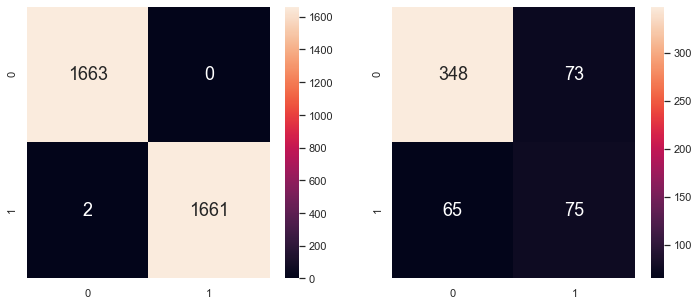

In [104]:
# Plot the Confusion Matrix
f, axes = plt.subplots(1, 2, figsize=(12, 5))
sb.heatmap(confusion_matrix(y_train2_res, y_train2_pred), annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test2, y_test2_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

In [105]:
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", forest2.score(X_train2_res, y_train2_res))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", forest2.score(X_test2, y_test2))
print()

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.9993986770895971

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.7540106951871658



In [106]:
TN_2, FP_2, FN_2, TP_2 = confusion_matrix(y_test2, y_test2_pred).ravel()

print(TN_2, FP_2, FN_2, TP_2)
print()

print("FPR =", FP_2/(FP_2+TN_2))

print("FNR =", FN_2/(FN_2+TP_2))

348 73 65 75

FPR = 0.17339667458432304
FNR = 0.4642857142857143


In [107]:
test_prediction_drop1 = forest2.predict(dropped_preds_test)

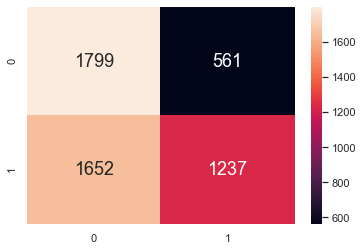

In [109]:
sb.heatmap(confusion_matrix(superhost_df_test, test_prediction_drop1), annot = True, fmt=".0f", annot_kws={"size": 18})


In [111]:
from sklearn.metrics import classification_report

In [113]:
print(classification_report(superhost_df_test, test_prediction_drop1))


              precision    recall  f1-score   support

           0       0.52      0.76      0.62      2360
           1       0.69      0.43      0.53      2889

    accuracy                           0.58      5249
   macro avg       0.60      0.60      0.57      5249
weighted avg       0.61      0.58      0.57      5249



In [114]:
svc2 = NuSVC()

In [115]:
svc2.fit(X_train2_res, y_train2_res) # train the model

NuSVC(break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
      max_iter=-1, nu=0.5, probability=False, random_state=None, shrinking=True,
      tol=0.001, verbose=False)

In [117]:
y_train_pred10 = svc2.predict(X_train2_res)
y_test_pred10 = svc2.predict(X_test2)

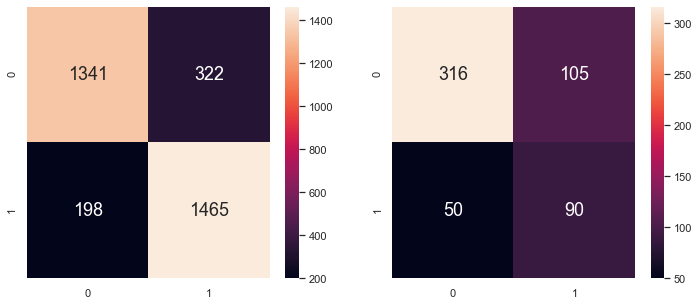

In [118]:
# Plot the Confusion Matrix
f, axes = plt.subplots(1, 2, figsize=(12, 5))
sb.heatmap(confusion_matrix(y_train2_res, y_train_pred10), annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test2, y_test_pred10), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

In [119]:
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", svc2.score(X_train2_res, y_train2_res))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", svc2.score(X_test2, y_test2))
print()

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.8436560432952496

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.7237076648841355



In [121]:
test_prediction_drop2 = svc2.predict(dropped_preds_test)

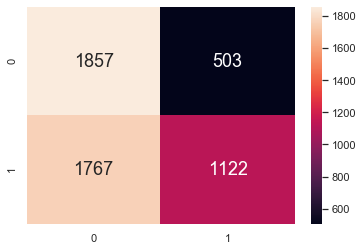

In [122]:
sb.heatmap(confusion_matrix(superhost_df_test, test_prediction_drop2), annot = True, fmt=".0f", annot_kws={"size": 18})


In [123]:
print(classification_report(superhost_df_test, test_prediction_drop2))

              precision    recall  f1-score   support

           0       0.51      0.79      0.62      2360
           1       0.69      0.39      0.50      2889

    accuracy                           0.57      5249
   macro avg       0.60      0.59      0.56      5249
weighted avg       0.61      0.57      0.55      5249



Logistic Regression; uses a logistic function to model the probabilities for binary classification

In [124]:
log2 = LogisticRegression( solver='liblinear')

In [125]:
log2.fit(X_train2_res, y_train2_res) # train the model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [127]:
y_train_pred11 = log2.predict(X_train2_res)
y_test_pred11 = log2.predict(X_test2)

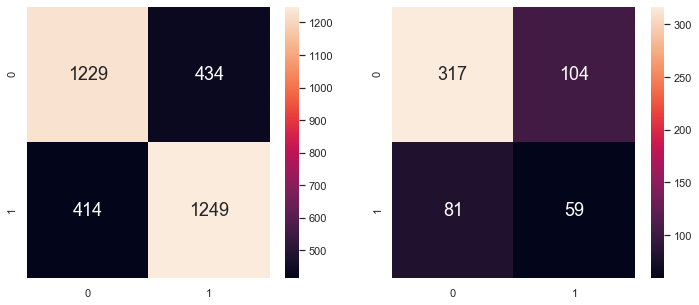

In [128]:
# Plot the Confusion Matrix
f, axes = plt.subplots(1, 2, figsize=(12, 5))
sb.heatmap(confusion_matrix(y_train2_res, y_train_pred11), annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test2, y_test_pred11), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

In [129]:
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", log2.score(X_train2_res, y_train2_res))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", log2.score(X_test2, y_test2))
print()

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.7450390859891762

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.6702317290552585



In [130]:
test_prediction_drop3 = log2.predict(dropped_preds_test)

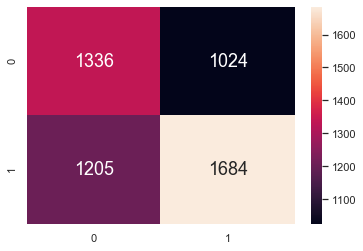

In [131]:
sb.heatmap(confusion_matrix(superhost_df_test, test_prediction_drop3), annot = True, fmt=".0f", annot_kws={"size": 18})


In [133]:
print(classification_report(superhost_df_test, test_prediction_drop3))

              precision    recall  f1-score   support

           0       0.53      0.57      0.55      2360
           1       0.62      0.58      0.60      2889

    accuracy                           0.58      5249
   macro avg       0.57      0.57      0.57      5249
weighted avg       0.58      0.58      0.58      5249



In [135]:
superhost_df_test.value_counts(normalize = True)

1    0.550391
0    0.449609
Name: host_is_superhost, dtype: float64

Scores are higher than that of a dummy classifier, but not much of a difference after removing the time-based and other predictors